# 6.4 컨브넷을 사용한 시퀀스 처리

### 1D Convnet

- **1D Convnet은 2D Convnet에서의 이미지의 높이, 너비(2차원)를 시간(1차원)으로 바꾼 것**

- Convnet이 입력의 부분 패치에서 특성을 뽑아내 구조적인 표현을 만들 수 있다는 특징을 이용
    - 1D Convnet의 부분 패치 크기 : (time)
    - 2D Convnet의 부분 패치 크기 : (height, width)
    
    
- 1D Convnet은 최근 오디오 생성과 기계 번역 분야에서 큰 성공을 거두었음
    
    
### 1D Convnet의 특징

- 1D Convnet은 시퀀스 처리에서 **RNN에 비해 계산비용이 적음**
- 1D Convnet은 전형적으로 dilated kernel과 함께 사용됨


#### 참고) Dilated convolution

- Dilated convolution(팽창 합성곱)은 커널에 구멍을 추가하여 큰 범위로 receptive field를 늘리는 방법
    - receptive field는 필터가 보는 영역을 뜻함
    

- 진한 파랑 아래 그림의 진한 파랑부분만 weight가 있고 나머지 부분(구멍 부분)은 0으로 채워짐


<img src="./images/dilated_conv.gif" alt="dilated" align="left"/>

## 6.4.1 시퀀스 데이터를 위한 1D 합성곱 이해하기

### 1D Convolution의 동작 방식

1. 입력 시퀀스에서 시간 축으로 1D 패치(부분 시퀀스)를 추출



2. 추출된 패치에 대해 1D 합성곱을 적용
    - 합성곱을 통해 나온 출력이 타임스텝이 됨

<img src="./images/1d_conv.png" alt="1d_conv" align="left"/>

### 시퀀스 지역 패턴 인식

- **1D 합성곱 층은 시퀀스의 지역 패턴을 인식할 수 있음**
    - 특정 위치에서 학습한 패턴을 나중에 다른 위치에서 인식할 수 있음
    - 시퀀스의 시간의 이동에 대한 불변성을 제공
    
예) 크기가 5인 윈도우를 사용해 문자 시퀀스를 처리하는 경우, 1D Convnet은 5개 이하의 단어나 단어의 부분을 학습하며 이 Convnet은 단어가 입력 시퀀스의 어느 문장에 있더라도 인식할 수 있음
        

## 6.4.2 시퀀스 데이터를 위한 1D 풀링

### 1D Pooling

- 1D Pooling은 2D Pooling연산과 마찬가지로 **1D 입력의 길이를 줄이기 위해 사용(subsampling)**
- 입력에서 1D 패치(부분 시퀀스)를 추출하고, 최댓값이나 평균값을 출력

## 6.4.3 1D 컨브넷 구현

### 1D 컨브넷 구현

- keras에서는 `Conv1D`를 사용해 구현


- 입력 텐서의 크기 : `(samples, time, features)`
    - 2D Convnet의 이미지 입력 텐서의 크기`(samples, height, width, features)`에서 height, width가 time이 됨
    - 합성곱 윈도우는 시간 축의 1D 윈도우(입력 텐서의 2번째 축)
    

- 큰 합성곱 윈도우 크기 사용
    - 2D 컨브넷에서 크기가 3인 합성곱 윈도우는 3x3=9개의 특성을 고려
    - 1D 컨브넷에서 크기가 3인 합성곱 윈도우는 3개의 특성을 고려
    - 따라서, 1D 컨브넷에서는 큰 윈도우 크기인 7이나 9를 적용할 수 있음
    
    
### 네트워크 구성 (2D Convnet과 비슷함)

1. Conv1D, MaxPooling1D를 쌓음
2. 전역 풀링 층이나 Flatten층을 쌓음
3. 분류나 회귀를 위한 Dense층을 추가


#### 전역 풀링 층

- `GlobalAveragePooling1D`, `GlobalMaxPooling1D` : 시간 축 전체에 풀링
    - 입력 : `(samples, timesteps, features)`
    - 출력 : `(samples, features)`
    

- `GlobalAveragePooling2D`, `GlobalMaxPooling2D` : 특성 맵의 공간 차원 전체에 대한 풀링
    - 입력 : `(samples, height, width, channels)`
    - 출력 : `(samples, channels)`

### IMDB 감성 분류 예제

In [33]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(25000, 500) (25000,)
(25000, 500) (25000,)


In [42]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers

model = models.Sequential()

model.add(layers.Embedding(max_features, 32, input_length=max_len))

model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(1))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 500, 32)           320000    
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 494, 32)           7200      
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 98, 32)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 92, 32)            7200      
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 18, 32)            0         
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)               

In [43]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.0001),
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 135us/sample - loss: 0.7717 - acc: 0.5128 - val_loss: 0.6911 - val_acc: 0.5158
Epoch 2/10
20000/20000 [==============================] - 3s 129us/sample - loss: 0.6803 - acc: 0.6098 - val_loss: 0.6795 - val_acc: 0.5918
Epoch 3/10
20000/20000 [==============================] - 2s 117us/sample - loss: 0.6623 - acc: 0.6869 - val_loss: 0.6608 - val_acc: 0.6640
Epoch 4/10
20000/20000 [==============================] - 2s 105us/sample - loss: 0.6331 - acc: 0.7424 - val_loss: 0.6258 - val_acc: 0.7138
Epoch 5/10
20000/20000 [==============================] - 2s 107us/sample - loss: 0.5794 - acc: 0.7782 - val_loss: 0.5542 - val_acc: 0.7660
Epoch 6/10
20000/20000 [==============================] - 2s 120us/sample - loss: 0.4904 - acc: 0.8112 - val_loss: 0.4616 - val_acc: 0.8102
Epoch 7/10
20000/20000 [==============================] - 2s 98us/sample - loss: 0.4143 - acc: 0.8397 - val_los

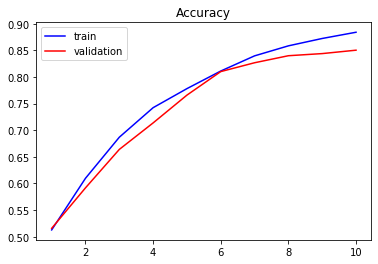

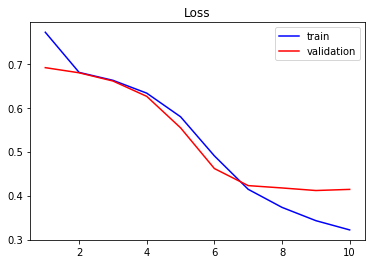

In [44]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b', label='train')
plt.plot(epochs, val_acc, 'r', label='validation')
plt.title("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='train')
plt.plot(epochs, val_loss, 'r', label='validation')
plt.title("Loss")
plt.legend()

plt.show()

#### 결과 분석

- 6.2절의 LSTM을 사용한 모델보다 성능은 조금 떨어지만 학습 속도가 약 10배나 빨라짐

- 매우 복잡한 문제가 아닌 경우, 순환 네트워크를 대신해 경제적인 1D 컨브넷을 사용할 수 있다는 것을 보여줌